# Retail Promotion Classification-Prediction Problem
## Vasundhara Bagchi, Elizabeth Slesarev, and Paul Beltran 

Through this project, we are aiming to use retail sales data to understand how the stores could run a personalized and targeted promotional campaigns based on customers' purchasing patterns in different categories. 

This project would allow retail stores, particularly one without a lot of resources dedicated to promotional material, to optimize their promotional campaigns by identifying the most effective customer profiles to target with their marketing efforts. This approach can save retailers significant resources and effort by avoiding a standarized approach to promotions, which can be less effective and less efficient. Instead, stores can target specific customer segments based on their preferences in shopping categories, past purchasing behaviors, and other factors to maximize the effectiveness of their promotions.

**Part 1:**

Our initial problem statement focuses on predicting whether or not we should market to a customer based on the amount of money they spent in a certain category when focusing on promotional material for that category. However, we soon run into issues regarding [] and have to take a different approach to tackling this overall task. 

**Part 2:**

Our updated problem statement now focuses on a predictive model for shopper segmentation, where shoppers are grouped into distinct categories based on their preferences and purchase patterns. Eg: Technology enthusiasts, food connoisseurs, fashion-conscious individuals, and beauty enthusiasts.
This segmentation would help businesses optimize marketing strategies through targeted promotional campaigns and personalized recommendations to ultimately increase customer retention while optimizing their resources.

**Part 3:**

Let's do an extra classification, is our data truly seperable?

### About the dataset 
This particular dataset contains data from various age groups and genders several categories from 10 shopping malls in Istanbul, Turkey. 

Data Source: https://www.kaggle.com/datasets/mehmettahiraslan/customer-shopping-dataset

### Step 1: Data Cleaning and Preprocessing

Imports

In [59]:
# Python basics for data analysis and transform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Our models
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.multiclass import OneVsRestClassifier
# import tensorflow as tf
# from tensorflow import keras
# from keras.utils import to_categorical
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras import regularizers

# Data meterics and testing
from sklearn.model_selection import (
    StratifiedKFold,
    train_test_split, 
    cross_val_score,
    StratifiedKFold, 
    KFold,
    GridSearchCV,
)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    precision_score, 
    recall_score,
)

### Description of the features: 

1. invoice_no: Invoice number. Nominal. A combination of the letter 'I' and a 6-digit integer uniquely assigned to each operation. <br><br>
2. customer_id: Customer number. Nominal. A combination of the letter 'C' and a 6-digit integer uniquely assigned to each operation.<br><br>
3. gender: String variable of the customer's gender.<br><br>
4. age: Positive Integer variable of the customers age.<br><br>
5. category: String variable of the category of the purchased product.<br><br>
6. quantity: The quantities of each product (item) per transaction. Numeric.<br><br>
7. price: Unit price. Numeric. Product price per unit in Turkish Liras (TL).<br><br>
8. payment_method: String variable of the payment method (cash, credit card or debit card) used for the transaction.<br><br>
9. invoice_date: Invoice date. The day when a transaction was generated.<br><br>
10. shopping_mall: String variable of the name of the shopping mall where the transaction was made.<br><br>

### Reading in the data 
We read in the data source via pandas and visualize it to see the columns present and determine which ones will be useful for our purposes. 

In [60]:
df = pd.read_csv('customer_shopping_data.csv')
df.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,I337046,C189076,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon


### Feature Engineering

After looking over the data, we use domain knowledge to recognize that there were certain features that would not have any real impact on shopper's shopping patterns. We therefore drop these columns.
For our purposes in this problem, we are not using 'invoice_no', 'customer_id', 'payment_method', 'invoice_date', data attributes from the dataset. 

We also want to restrict this demonstration to a couple of the main categories, so we are dropping the other categories, including Toys, Souveniers, Books, Shoes. 

In [61]:
# grabbing columns that are useful and dropping all else
df.drop(['invoice_no', 'customer_id', 'payment_method', 'invoice_date'], axis=1, inplace=True)

# dropping rows we dont care about, like toys

df.drop(df[df['category'] == 'Toys'].index, inplace = True)
df.drop(df[df['category'] == 'Souvenir'].index, inplace = True)
df.drop(df[df['category'] == 'Books'].index, inplace = True)
df.drop(df[df['category'] == 'Shoes'].index, inplace = True)

We notice that there is a price column and a quantity column, but that is not as meaningful as a total price column which will be an useful feature in our problem. We are thus calculating the new feature, **total price**, by multiplying the price and quantity columns. Once we add in this new feature, we drop the price and quantity columns as they do not provide us any new information. 

In [62]:
# recalculating price column to include totals
df['total_price'] = (df['price'] * df['quantity'])
df.drop(['quantity', 'price'], axis=1, inplace=True)
df.head()

,gender,age,category,shopping_mall,total_price
0,Female,28,Clothing,Kanyon,7502.00
2,Male,20,Clothing,Metrocity,300.08
5,Female,28,Clothing,Forum Istanbul,7502.00
6,Female,49,Cosmetics,Istinye Park,40.66
7,Female,32,Clothing,Mall of Istanbul,1200.32


Finally, we also want to know how many data points there are for each category to get a better sense of the spread of our dataset. It looks like we have an imbalanced dataset which Technology having far fewer samples than Clothing. This will come into play later when we choose between K-fold and Stratified K-fold cross validation techniques. 

In [63]:
df['category'].value_counts()

Clothing           34487
Cosmetics          15097
Food & Beverage    14776
Technology          4996
Name: category, dtype: int64

It looks like clothing is the majority class whereas Technology is the minority class. 
One way to level this out is by oversampling Technology or undersampling Clothing.

### Visualizing the cleaned data 

One of the first pieces we want to visualize and compare is the total amount of money spent by females vs. men.

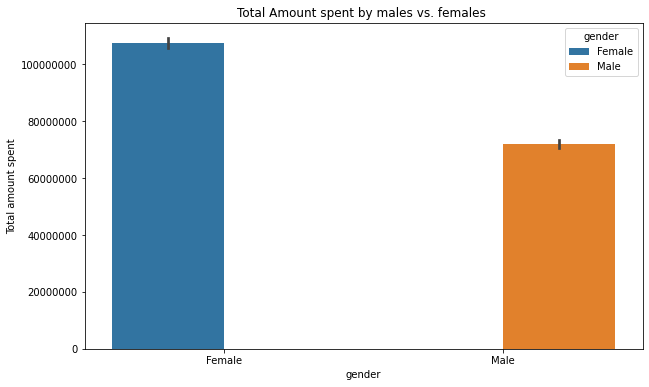

In [64]:
plt.figure(figsize=(10,6))
sns.barplot(df,x='gender',y='total_price',hue = 'gender',estimator = sum)
plt.ylabel('Total amount spent')
plt.title('Total Amount spent by males vs. females ')
plt.ticklabel_format(style='plain',axis='y')
plt.show()

It is evident that the overall total amount of money spent by females is considerably higher. 

Next, we want to comapare the amount of money spent per category by males vs. females 

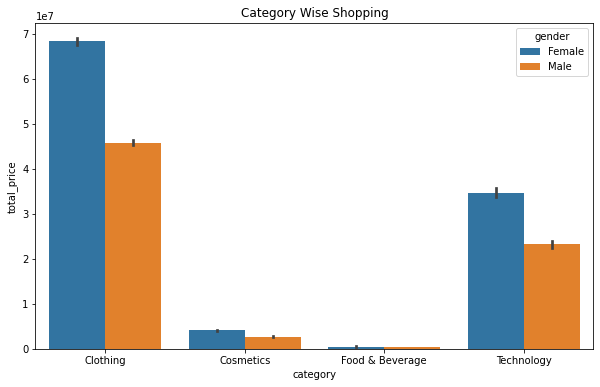

In [65]:
plt.figure(figsize=(10,6))
sns.barplot(df,x='category',y='total_price',hue = 'gender',estimator = sum)
plt.title('Category Wise Shopping')
plt.show()

It looks like the total amount of money spent in clothing, cosmetics, and technology by females is considerably higher than the total amount of money spent by men in those categories, but we want to see if this same trend follows for the average amount of money spent by females vs. males in each of these categories. 

**Calculating average amount of money spent by females vs. males in each of these categories:**

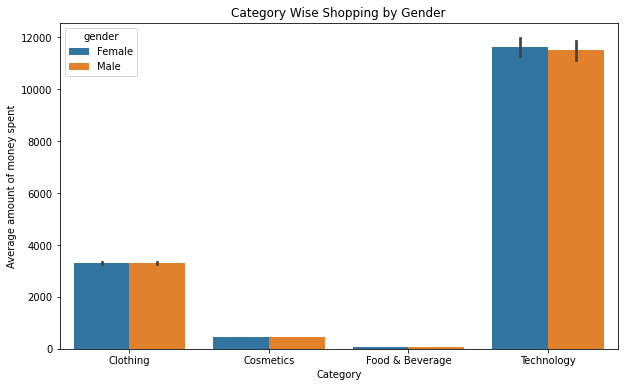

In [66]:
plt.figure(figsize=(10,6))
ax = sns.barplot(df,x='category',y='total_price',hue = 'gender',estimator = 'mean')
ax.set(xlabel='Category',
       ylabel='Average amount of money spent',
       title='Category Wise Shopping by Gender')
plt.show()

In [67]:
# checking average price spent by gender per category
avg_price_spent_per=df.groupby(['gender','category'], as_index=False)['total_price'].mean()
avg_age_per=df.groupby(['gender','category'], as_index=False)['age'].mean()
print(avg_price_spent_per)
print("\n",avg_age_per)

   gender         category   total_price
0  Female         Clothing   3304.846775
1  Female        Cosmetics    448.376245
2  Female  Food & Beverage     57.396933
3  Female       Technology  11630.308621
4    Male         Clothing   3306.475999
5    Male        Cosmetics    452.312985
6    Male  Food & Beverage     57.637718
7    Male       Technology  11509.875931

    gender         category        age
0  Female         Clothing  43.381948
1  Female        Cosmetics  43.571665
2  Female  Food & Beverage  43.489209
3  Female       Technology  43.249581
4    Male         Clothing  43.449946
5    Male        Cosmetics  43.594160
6    Male  Food & Beverage  43.155727
7    Male       Technology  43.544417


We quickly find a couple of things: 
1.  There is a noticeable amount of difference between males and females in total amount spent per category
2. There is a noticeable amount of difference between average spending from category to category 
3. There is very little difference in when comparing males vs. females **within** each category. For example, for the Technology category, Males spent an average of 11509.88 Lira wheras females spent 11630.31 Lira and in the Clothing category, males spent an average of 3306.48  Lira whereas females spent an average of 3304.85 Lira. 

There lack of variation in our data will become a problem as we will find out later 

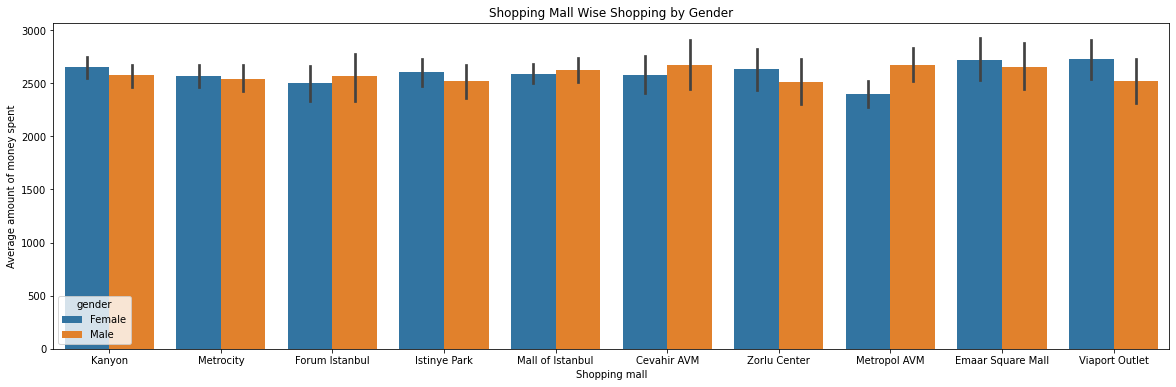

In [68]:
plt.figure(figsize=(20,6))
ax = sns.barplot(df,x='shopping_mall',y='total_price',hue = 'gender',estimator = 'mean')
ax.set(xlabel='Shopping mall',
       ylabel='Average amount of money spent',
       title='Shopping Mall Wise Shopping by Gender')
plt.show()

In [69]:
avg_price_spent_per=df.groupby(['gender','shopping_mall'], as_index=False)['total_price'].mean()
print(avg_price_spent_per)

    gender      shopping_mall  total_price
0   Female        Cevahir AVM  2578.274630
1   Female  Emaar Square Mall  2721.922403
2   Female     Forum Istanbul  2498.865477
3   Female       Istinye Park  2601.940877
4   Female             Kanyon  2652.917047
5   Female   Mall of Istanbul  2588.465487
6   Female          Metrocity  2565.397838
7   Female       Metropol AVM  2399.639890
8   Female     Viaport Outlet  2723.107971
9   Female       Zorlu Center  2628.558746
10    Male        Cevahir AVM  2666.947484
11    Male  Emaar Square Mall  2652.309208
12    Male     Forum Istanbul  2567.935761
13    Male       Istinye Park  2516.635455
14    Male             Kanyon  2572.807329
15    Male   Mall of Istanbul  2626.392354
16    Male          Metrocity  2540.795903
17    Male       Metropol AVM  2670.127212
18    Male     Viaport Outlet  2517.975887
19    Male       Zorlu Center  2509.945500


There is very little difference in when comparing males vs. females **within** for each shopping mall as well.  

# Part 1: Tackling the Initial Problem Statement 

### Creating class labels for our dataset 

After visualizing and understanding our dataset, we will now be creating class labels for our dataset. We want to have 3 labels - Yes, No, and Maybe which represent if we should market to this person based on their shopping habits - i.e amount of money spent in a particular category. 

Our cutoffs of creating each of these labels will be based on total cost percentiles per category - 


1. **Yes** - This person's total cost in a certain category is more than the 75 percentile of total money spent in that certain category, therfore, we will defintely want to market to these people. 


2. **Maybe** - This person's total cost in a certain category is less than the 75 percentile but more than the 25 percentile of total money spent in that certain category, therfore, we will may want to market to these people, but will want to give higher priority to people who have spent more money. 


3. **No** -  This person's total cost in a certain category is less than the 25 percentile but more than the median of total money spent in that certain category, therfore, we do not want to market to these people and conserve our resources instead. 

In [70]:
df.groupby(['gender','category'], as_index=False)['total_price'].describe()

gender  0     Female
        1     Female
        2     Female
        3     Female
        4       Male
              ...   
max     3    26250.0
        4     7502.0
        5     1016.5
        6     130.75
        7    26250.0
Length: 80, dtype: object

In [71]:
df.groupby(['gender','category'], as_index=False)['age'].describe()

gender  0    Female
        1    Female
        2    Female
        3    Female
        4      Male
              ...  
max     3      69.0
        4      69.0
        5      69.0
        6      69.0
        7      69.0
Length: 80, dtype: object

Now that we have found the 25th, 50th, and 75th percentiles. We use the rules above to assign class labels. 

In [72]:
# creating the class label
# label -> ['maybe', 'no', 'yes']
def assignNewLabels(row):
    # for tech shoppers
    if row['category'] == "Technology" and row["total_price"] > 16800:
        return "yes"
    elif row['category'] == "Technology" and row["total_price"] <= 4200:
        return "no"
    elif row['category'] == "Technology" and row["total_price"] > 4200.0 and row["total_price"] <= 16800:
        return "maybe"
    
    # for clothing
    elif row['category'] == "Clothing" and row["total_price"] > 4801.28:
        return "yes"
    elif row['category'] == "Clothing" and row["total_price"] <= 1200.32:
        return "no"
    elif row['category'] == "Clothing" and row["total_price"] > 1200.32 and row["total_price"] <= 4801.28:
        return "maybe"
    
    # for cosmetics
    elif row['category'] == "Cosmetics" and row["total_price"] > 650.56:
        return "yes"
    elif row['category'] == "Cosmetics" and row["total_price"] <= 162.64:
        return "no"
    elif row['category'] == "Cosmetics" and row["total_price"] > 162.64 and row["total_price"] <= 650.56:
        return "maybe"
    
    # for food
    elif row['category'] == "Food & Beverage" and row["total_price"] > 83.68:
        return "yes"
    elif row['category'] == "Food & Beverage" and row["total_price"] <= 20.92:
        return "no"
    elif row['category'] == "Food & Beverage" and row["total_price"] > 20.92 and row["total_price"] <= 83.68:
        return "maybe"

In [73]:
# creating the labels based on the above function
df['Should_We_Market'] = df.apply(lambda row: assignNewLabels(row), axis=1)
df.head()

,gender,age,category,shopping_mall,total_price,Should_We_Market
0,Female,28,Clothing,Kanyon,7502.00,yes
2,Male,20,Clothing,Metrocity,300.08,no
5,Female,28,Clothing,Forum Istanbul,7502.00,yes
6,Female,49,Cosmetics,Istinye Park,40.66,no
7,Female,32,Clothing,Mall of Istanbul,1200.32,no


We now have our new class labels that our models will now try to predict. 

### Starting the Machine Learning Process 
**One Hot Encoding**

We are creating one hot encoded labels for each gender and category features as we are doing multilclass classification. We chose to opt in for this as opposed to just integer labels like 1, 2, 3, 4 corresponding to each category because we do not want there to be assumed ordinal relationship between the categories. 

In [74]:
df_dummy = pd.get_dummies(df[['gender', 'category', 'age', 'total_price', 'shopping_mall']])
df_dummy.head()

,age,total_price,gender_Female,gender_Male,category_Clothing,category_Cosmetics,category_Food & Beverage,category_Technology,shopping_mall_Cevahir AVM,shopping_mall_Emaar Square Mall,shopping_mall_Forum Istanbul,shopping_mall_Istinye Park,shopping_mall_Kanyon,shopping_mall_Mall of Istanbul,shopping_mall_Metrocity,shopping_mall_Metropol AVM,shopping_mall_Viaport Outlet,shopping_mall_Zorlu Center
0,28,7502.00,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2,20,300.08,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0
5,28,7502.00,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
6,49,40.66,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
7,32,1200.32,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


**Min-max normalization**

We normalize our age and price features to ensure uniformity and ensure that they are all within the same range, [0,1]


In [75]:
# Normalizing the ages
min_age = df_dummy['age'].min()
max_age = df_dummy['age'].max()

# Apply min-max normalization to the 'age' column
df_dummy['normalized_age'] = (df_dummy['age'] - min_age) / (max_age - min_age)
df_dummy.drop(['age'], axis=1, inplace=True)

In [76]:
# Normalize the prices
min_price = df_dummy['total_price'].min()
max_price = df_dummy['total_price'].max()

# Apply min-max normalization to the 'price' column
df_dummy['normalized_price'] = (df_dummy['total_price'] - min_price) / (max_price - min_price)
df_dummy.drop(['total_price'], axis=1, inplace=True)

In [77]:
df_dummy.head()

,gender_Female,gender_Male,category_Clothing,category_Cosmetics,category_Food & Beverage,category_Technology,shopping_mall_Cevahir AVM,shopping_mall_Emaar Square Mall,shopping_mall_Forum Istanbul,shopping_mall_Istinye Park,shopping_mall_Kanyon,shopping_mall_Mall of Istanbul,shopping_mall_Metrocity,shopping_mall_Metropol AVM,shopping_mall_Viaport Outlet,shopping_mall_Zorlu Center,normalized_age,normalized_price
0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0.196078,0.285648
2,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0.039216,0.011235
5,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0.196078,0.285648
6,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0.607843,0.001350
7,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0.274510,0.045536


We are now ready to run our models

## Running the Models

We are working with a 80/20 train test split for all of our models. 

We start with a Gaussian Naive Bayes. We chose this model because of its simplicity and overall effectiveness. Since our dataset is fairly simple, we expect a high accuracy without optimization, and chances of overfitting will be low for this particular classification.

### Gaussian Naive Bayes with labels = yes or no or maybe

In [78]:
# Naive Bayes Model formatting
X = df_dummy
y = df.Should_We_Market

print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=125
)

(69356, 18) (69356,)


Accuracy: 0.6008506343713956
F1 Score: 0.6575598917743605

Precision for Label maybe : 0.6384685923888125
Precision for Label no : 0.5991282968261064
Precision for Label yes : 0.33629893238434166

Recall for Label maybe : 0.49910394265232977
Recall for Label no : 0.9643820831084727
Recall for Label yes : 0.06915477497255763


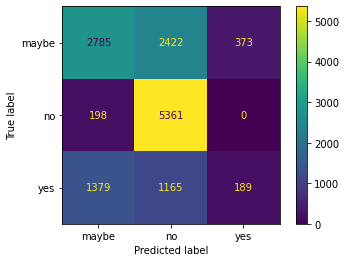

In [79]:
# Build a Gaussian Classifier
model = GaussianNB()

# Model training
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="weighted")

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print()

cm = confusion_matrix(y_test, y_pred, labels=["maybe", "no", "yes"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["maybe", "no", "yes"])
disp.plot();

# Calculate recall and precision per label
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
labels = sorted(set(y_test))

for label, score in zip(labels, precision):
    print("Precision for Label", label, ":", score)
print()
for label, score in zip(labels, recall):
    print("Recall for Label", label, ":", score)

In [80]:
# Assuming your DataFrame is called df and contains the 4 features and 3 labels
# Let's say the 4 features are 'feature1', 'feature2', 'feature3', 'feature4'
# And the label column is called 'label'

# Select the relevant columns for correlation analysis
selected_columns = df_dummy.columns.tolist()
df_selected = df_dummy[selected_columns]

# Calculate the correlation coefficients
correlation_matrix = df_selected.corr()

# Print the correlation matrix
print(correlation_matrix)


                                 gender_Female  gender_Male  \
gender_Female                         1.000000    -1.000000   
gender_Male                          -1.000000     1.000000   
category_Clothing                     0.000753    -0.000753   
category_Cosmetics                    0.002495    -0.002495   
category_Food & Beverage             -0.002794     0.002794   
category_Technology                  -0.001015     0.001015   
shopping_mall_Cevahir AVM            -0.004580     0.004580   
shopping_mall_Emaar Square Mall      -0.006902     0.006902   
shopping_mall_Forum Istanbul          0.004914    -0.004914   
shopping_mall_Istinye Park            0.003032    -0.003032   
shopping_mall_Kanyon                  0.004849    -0.004849   
shopping_mall_Mall of Istanbul       -0.001230     0.001230   
shopping_mall_Metrocity              -0.002554     0.002554   
shopping_mall_Metropol AVM            0.003761    -0.003761   
shopping_mall_Viaport Outlet         -0.000451     0.00

We can see that accuracy is low, and we realize further that this is wrong for the following reasons:

1. We calculated the labels based on the total_price column of the feature set, thereby increasing correlation significantly between these two variables, and making classification innacurate since the data was already given to the label, making prediction much harder.
2. Naive-Bayes assumes independence between features, however, this dataset shows strong dependence between features such as gender (both are strongly negatively correlated).

Now we will repurpose our statement to classify shopper's spending categories based on spending habits and gender and age instead.

# Part 2: Updated Problem Statement 

We now want to move onto our updated problem statement of focusing on a predictive model for shopper segmentation, where shoppers are grouped into distinct categories based on their preferences and purchase patterns. We want to step away from the yes, maybe, no concept of the class label entirely due to the aforementioned reasons and pivot into something that is more applicable of an implementation. 

We are now predicting the Category label given the features of age, gender, shopping mall, and total price to start with to essentially utilize this demographic and past purchasing information to segment shoppers into categories, which can then be utilized for any future targeted marketing campaigns Eg: Aiming to focus on technology enthusiasts for a technology sale.  

## Random Forest Classification for Feature Selection

We first take a step back and create one hot-encodings with the features we want once more. 

In [81]:
df_dummy = pd.get_dummies(df[['gender', 'age', 'total_price', 'shopping_mall']])
df_dummy.head()

,age,total_price,gender_Female,gender_Male,shopping_mall_Cevahir AVM,shopping_mall_Emaar Square Mall,shopping_mall_Forum Istanbul,shopping_mall_Istinye Park,shopping_mall_Kanyon,shopping_mall_Mall of Istanbul,shopping_mall_Metrocity,shopping_mall_Metropol AVM,shopping_mall_Viaport Outlet,shopping_mall_Zorlu Center
0,28,7502.00,1,0,0,0,0,0,1,0,0,0,0,0
2,20,300.08,0,1,0,0,0,0,0,0,1,0,0,0
5,28,7502.00,1,0,0,0,1,0,0,0,0,0,0,0
6,49,40.66,1,0,0,0,0,1,0,0,0,0,0,0
7,32,1200.32,1,0,0,0,0,0,0,1,0,0,0,0


Normalizing the ages to ensure uniformity and bring them to the same range, [0,1] 

In [82]:
# Normalizing the ages
min_age = df_dummy['age'].min()
max_age = df_dummy['age'].max()

# Apply min-max normalization to the 'age' column
df_dummy['normalized_age'] = (df_dummy['age'] - min_age) / (max_age - min_age)

# Normalize the prices
min_price = df_dummy['total_price'].min()
max_price = df_dummy['total_price'].max()

# Apply min-max normalization to the 'total_price' column
df_dummy['normalized_price'] = (df_dummy['total_price'] - min_price) / (max_price - min_price)
df_dummy.drop(['total_price', 'age'], axis=1, inplace=True)
df_dummy.head()

,gender_Female,gender_Male,shopping_mall_Cevahir AVM,shopping_mall_Emaar Square Mall,shopping_mall_Forum Istanbul,shopping_mall_Istinye Park,shopping_mall_Kanyon,shopping_mall_Mall of Istanbul,shopping_mall_Metrocity,shopping_mall_Metropol AVM,shopping_mall_Viaport Outlet,shopping_mall_Zorlu Center,normalized_age,normalized_price
0,1,0,0,0,0,0,1,0,0,0,0,0,0.196078,0.285648
2,0,1,0,0,0,0,0,0,1,0,0,0,0.039216,0.011235
5,1,0,0,0,1,0,0,0,0,0,0,0,0.196078,0.285648
6,1,0,0,0,0,1,0,0,0,0,0,0,0.607843,0.001350
7,1,0,0,0,0,0,0,1,0,0,0,0,0.274510,0.045536


Finally, here we use we make use of sklearn’s Random Forest Classification to create a feature ranking 


In [83]:
X = df_dummy
y = df.category

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier()

rf_classifier.fit(X_train, y_train)

# Get feature importances
importances = rf_classifier.feature_importances_

# Sort feature importances in descending order
indices = importances.argsort()[::-1]
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. Feature {X.columns[indices[f]]} ({importances[indices[f]]})")

Feature ranking:
1. Feature normalized_price (0.9858060065593116)
2. Feature normalized_age (0.011846944180836592)
3. Feature gender_Female (0.0002520804182885779)
4. Feature gender_Male (0.00024285761940468056)
5. Feature shopping_mall_Metropol AVM (0.0002015694694363572)
6. Feature shopping_mall_Mall of Istanbul (0.0001988247971140352)
7. Feature shopping_mall_Istinye Park (0.00019841700931480318)
8. Feature shopping_mall_Metrocity (0.00019553445298010633)
9. Feature shopping_mall_Forum Istanbul (0.0001947729123729825)
10. Feature shopping_mall_Emaar Square Mall (0.00018771851933093808)
11. Feature shopping_mall_Viaport Outlet (0.00018471932100420173)
12. Feature shopping_mall_Zorlu Center (0.00016691130108420184)
13. Feature shopping_mall_Cevahir AVM (0.00016553639941709733)
14. Feature shopping_mall_Kanyon (0.00015810704010384475)


According to this dataset, gender and shopping mall dont make a big difference in classififcation which lines up with our earlier observations (mean spending is the same per category for males and females and mean spending is around the same in each shopping mall for males and females ), so let’s drop these and try Naive Bayes again.


### Gaussian Naive Bayes with new labels based on categories

In [84]:
# dropping useless features according to Random Forest
df_dummy.drop(['gender_Female', 'gender_Male', 'shopping_mall_Mall of Istanbul',
               'shopping_mall_Metrocity', 'shopping_mall_Forum Istanbul', 'shopping_mall_Viaport Outlet',
               'shopping_mall_Emaar Square Mall', 'shopping_mall_Kanyon', 'shopping_mall_Istinye Park',
               'shopping_mall_Zorlu Center', 'shopping_mall_Cevahir AVM', 'shopping_mall_Metropol AVM'], axis=1, inplace=True)

In [85]:
X = df_dummy
y = df.category

print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=125
)

(69356, 2) (69356,)


We are now just working with the following features to predict the category

In [86]:
X

,normalized_age,normalized_price
0,0.196078,0.285648
2,0.039216,0.011235
5,0.196078,0.285648
6,0.607843,0.001350
7,0.274510,0.045536
...,...,...
99446,0.274510,0.000000
99449,0.921569,0.011235
99453,0.176471,0.000598
99454,0.882353,0.000598


### Gaussian Naive Bayes: Round 2 


Class labels - 
<Clothing, Cosmetics, Food & Beverage, Technology>

Features - 
<normalized_Age, normalized_Total_Price> 



Accuracy: 0.8123558246828143
F1 Score: 0.814141426450746

Precision for Label Clothing : 0.9324958123953099
Precision for Label Cosmetics : 0.6092564491654021
Precision for Label Food & Beverage : 0.8169879854708019
Precision for Label Technology : 1.0

Recall for Label Clothing : 0.8043635312816068
Recall for Label Cosmetics : 0.7862271540469974
Recall for Label Food & Beverage : 1.0
Recall for Label Technology : 0.38317757009345793


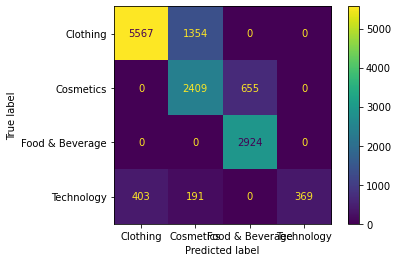

In [87]:
# Build a Gaussian Classifier
model = GaussianNB()

# Model training
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="weighted")

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print()

cm = confusion_matrix(y_test, y_pred, labels=["Clothing", "Cosmetics", "Food & Beverage", "Technology"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Clothing", "Cosmetics", "Food & Beverage", "Technology"])
disp.plot();

# Calculate recall and precision per label
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
labels = sorted(set(y_test))

for label, score in zip(labels, precision):
    print("Precision for Label", label, ":", score)
print()
for label, score in zip(labels, recall):
    print("Recall for Label", label, ":", score)


# interpret results in writeup using https://www.v7labs.com/blog/confusion-matrix-guide

Accuracy is a lot better because there is less dependency between the features, and labels were created without relying on any features.

We can see from the confusion matrix how clothing produced the most matches, and cosmetics provided least, but still produced a high recall and precision rate. As for technology and food & beverage labels, these are expectedly worse with recall on test data due to the size of sampling. As shown earlier, technology and food & bev. came last with least number of samples, making it so that they are likely to overfit quicker and perform worser on test data compared to the other labels. One way to fix this issue would be oversample technology and food & bev. labels. 

### Stratified K-fold cross validation for Naive Bayes without Gender and Shopping Mall features

We still conduct Stratified K-fold cross validation to re-evaluate the performace of our model to hopefully be made aware of any bias or overfitting. Here we are choosing to do 10-folds. We are choosing to use stratified k-fold because this is an imbalanced dataset, and there are many more samples of Food and Beverage than there are Technology, so by using stratified k-fold cross validation, we have a representative sample of all the classes in the dataset in each fold. 

In [88]:
kf = StratifiedKFold(n_splits=10, random_state=40, shuffle=True) 
accscore = []
classifier2 = GaussianNB()

for train_index , test_index in kf.split(X, y):
    X_train , X_test = X.iloc[train_index],X.iloc[test_index]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
     
    classifier2.fit(X_train, y_train.values.ravel())
    Y_pred = classifier2.predict(X_test)

     
    acc2 = accuracy_score(y_test, Y_pred)
    accscore.append(acc2)
     
avgscore = sum(accscore)/10
 
print("Accuracy from each fold = \n" + str(accscore))
print("\nAverage accuracy = \n" + str(avgscore))

Accuracy from each fold = 
[0.81199538638985, 0.8184832756632064, 0.8171856978085352, 0.8114186851211073, 0.8124279123414071, 0.828719723183391, 0.8152847873107426, 0.8116798846431147, 0.8108147080028839, 0.813410237923576]

Average accuracy = 
0.8151420298387814


Hmmm, seems like the gender and shopping mall features really did not matter in the long run. Lets try another classification technique instead!
(To learn more about stratified k-fold cross validation, visit here for more info: https://www.geeksforgeeks.org/stratified-k-fold-cross-validation/)

### Neural Networks:

In [89]:
df_norm = df[['age', 'total_price']].copy()
df_norm.head()

,age,total_price
0,28,7502.00
2,20,300.08
5,28,7502.00
6,49,40.66
7,32,1200.32


In [90]:
# Normalizing the ages
min_age = df_norm['age'].min()
max_age = df_norm['age'].max()

# Apply min-max normalization to the 'age' column
df_norm['normalized_age'] = (df_norm['age'] - min_age) / (max_age - min_age)

# Normalize the prices
min_price = df_norm['total_price'].min()
max_price = df_norm['total_price'].max()

# Apply min-max normalization to the 'price' column
df_norm['normalized_price'] = (df_norm['total_price'] - min_price) / (max_price - min_price)

# drop converted columns
df_norm.drop(['total_price', 'age'], axis=1, inplace=True)
df_norm.head()

,normalized_age,normalized_price
0,0.196078,0.285648
2,0.039216,0.011235
5,0.196078,0.285648
6,0.607843,0.001350
7,0.274510,0.045536


In [91]:
# Split the data into features and target
X = df_norm
y = df['category']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [92]:
# Encode target data to integer labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert target data to one-hot encoded format

#keras
# y_train_encoded = to_categorical(y_train_encoded, num_classes=4)
# y_test_encoded = to_categorical(y_test_encoded, num_classes=4)

In [93]:
# # converting to np arrays for model fitting with keras
# X_train_np = X_train.values
# X_test_np = X_test.values

In [94]:
# # Building our NN model
# model = keras.Sequential([
#     keras.layers.Dense(16, activation='relu', input_shape=(2,),kernel_regularizer=regularizers.l2(0.01)),
#     keras.layers.Dense(64, activation='relu'),
#     keras.layers.Dense(64, activation='relu'),
#     keras.layers.Dense(4, activation='softmax')
# ])

# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# history = model.fit(X_train_np, y_train_encoded, epochs=25, validation_data=(X_test_np, y_test_encoded))

In [95]:
# # Accessing loss and accuracy from the history object
# train_loss = history.history['loss']
# train_accuracy = history.history['accuracy']
# val_loss = history.history['val_loss']
# val_accuracy = history.history['val_accuracy']

# epochs_range = range(25)

# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
# plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, train_loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

As we can see from the plot, as we do more iterations of the NN, training and testing stay relatively similar, and increase in accuracy over time. 

In [96]:
# # Calculate training and testing errors
# train_pred = model.predict(X_train_np)
# test_pred = model.predict(X_test_np)
# train_error = mean_squared_error(y_train_encoded, train_pred)
# test_error = mean_squared_error(y_test_encoded, test_pred)

# print("Training Error:", train_error)
# print("Testing Error:", test_error)

# loss, accuracy = model.evaluate(X_test_np, y_test_encoded)
# print("Overall Accuracy:", accuracy)
# print("Overall Loss:", loss)

In [97]:
# import numpy as np
# from sklearn.metrics import confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Make predictions on test data
# y_pred_prob = model.predict(X_test_np)
# y_pred = np.argmax(y_pred_prob, axis=1)

# # Convert true labels to class labels if needed
# y_true = np.argmax(y_test_encoded, axis=1)

# # Create confusion matrix
# cm = confusion_matrix(y_true, y_pred)

# # Plot confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
# plt.title("Confusion Matrix")
# plt.xlabel("Predicted Labels")
# plt.ylabel("True Labels")
# plt.show()


As we can see from the plot, as we do more iterations of the NN, training and testing stay relatively similar, and increase in accuracy over time. Jus tlike in Naive-Bayes, Clothing label performs best.

### KNN 

# Part 3: Some More Experimentation

We wanted to try out a K-nearest neighbor algorithm as well to see if we are able to classify these categories. We chose this model because it handles multi-class classification well and reasoning that because the average prices each category were very different from each other, it would be a good algorithm to work with. 

We wanted to start with exploring the dataset a little bit more once again. This time, instead of grouping by gender and category, we are only grouping by category and looking at the distribution. 

In [98]:
df_normalized = df.copy()
df_normalized = df_normalized.drop(['shopping_mall', 'gender', 'Should_We_Market'], axis=1)

df_normalized.head()

df_notnorm = df_normalized.copy()
df_notnorm.head()

,age,category,total_price
0,28,Clothing,7502.00
2,20,Clothing,300.08
5,28,Clothing,7502.00
6,49,Cosmetics,40.66
7,32,Clothing,1200.32


Normalizing the total price and age to ensure that both features get equal amount of importance and is not skewed because of the much larger values of the total price. 

In [99]:
df_normalized.head()
min_price = df_normalized['total_price'].min()
max_price = df_normalized['total_price'].max()

# Apply min-max normalization to the 'price' column
df_normalized['normalized_price'] = (df_normalized['total_price'] - min_price) / (max_price - min_price)
df_normalized.drop(['total_price'], axis=1, inplace=True)

min_price = df_normalized['age'].min()
max_price = df_normalized['age'].max()

# Apply min-max normalization to the 'age' column
df_normalized['normalized_age'] = (df_normalized['age'] - min_price) / (max_price - min_price)
df_normalized.drop(['age'], axis=1, inplace=True)

df_normalized.head()


,category,normalized_price,normalized_age
0,Clothing,0.285648,0.196078
2,Clothing,0.011235,0.039216
5,Clothing,0.285648,0.196078
6,Cosmetics,0.001350,0.607843
7,Clothing,0.045536,0.274510


Let's look at the spread with the normalized features. 

In [100]:
df_normalized.groupby(['category'], as_index=False)['normalized_price'].describe().T.unstack()

,0,1,2,3
category,Clothing,Cosmetics,Food & Beverage,Technology
count,34487.0,15097.0,14776.0,4996.0
mean,0.12575,0.016945,0.001991,0.441098
std,0.098968,0.013407,0.001729,0.345612
min,0.011235,0.00135,0.0,0.039809
25%,0.045536,0.005998,0.000598,0.159833
50%,0.102706,0.013744,0.001594,0.359872
75%,0.182743,0.024589,0.002989,0.639928
max,0.285648,0.038532,0.004783,1.0


It already seems to appear that, for price, the means are vastly different from category to category. To get a better sensw of these values, let's look at the not normalized version of his dataset. 

In [101]:
df_notnorm.groupby(['category'], as_index=False)['total_price'].describe().T.unstack()


,0,1,2,3
category,Clothing,Cosmetics,Food & Beverage,Technology
count,34487.0,15097.0,14776.0,4996.0
mean,3305.500364,449.947864,57.494251,11581.735388
std,2597.40462,351.873613,45.385558,9070.511913
min,300.08,40.66,5.23,1050.0
25%,1200.32,162.64,20.92,4200.0
50%,2700.72,365.94,47.07,9450.0
75%,4801.28,650.56,83.68,16800.0
max,7502.0,1016.5,130.75,26250.0


In [102]:
df_notnorm.groupby(['category'], as_index=False)['age'].describe().T.unstack()


,0,1,2,3
category,Clothing,Cosmetics,Food & Beverage,Technology
count,34487.0,15097.0,14776.0,4996.0
mean,43.409227,43.580645,43.354426,43.368495
std,14.998012,14.936556,14.981172,14.83533
min,18.0,18.0,18.0,18.0
25%,30.0,31.0,31.0,31.0
50%,43.0,44.0,43.0,43.0
75%,56.0,56.0,56.0,56.0
max,69.0,69.0,69.0,69.0


Looking at the non-normalized version of the dataset and visualizing its spread across categories, we observe a couple of things: 
1. The means for total_price are very different from category to category. The standard deviations are also vastly varying. 
2. The means for age are pretty much consistent at ~43 from category to category. The standard deviations are also about the same at ~14.85 

Now that we have done some additional data explorations and are aware of the distrubiton of this dataset, let us start our model 

Here we choose to start doing KNN with k = 5 neighbors because we only have 5 categories want to initially have flexibility in our decision boundaries. We will later we checking accuracy vs. k value to find the optimal value for k. 

Accuracy:1.0
F1 score:1.0

Precision for Label Clothing : 1.0
Precision for Label Cosmetics : 1.0
Precision for Label Food & Beverage : 1.0
Precision for Label Technology : 1.0

Recall for Label Clothing : 1.0
Recall for Label Cosmetics : 1.0
Recall for Label Food & Beverage : 1.0
Recall for Label Technology : 1.0


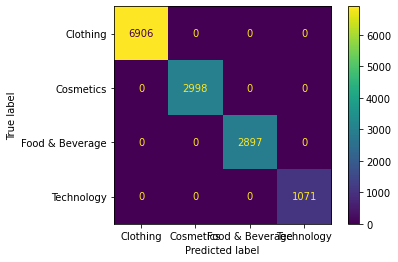

In [103]:
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)
Y_pred = classifier.predict(X_test)

acc = accuracy_score(y_test, Y_pred)
print ("Accuracy:" + str(acc))
f1 = f1_score(Y_pred, y_test, average="weighted")
print ("F1 score:" + str(f1))
print()

cm = confusion_matrix(y_test, Y_pred, labels=["Clothing", "Cosmetics", "Food & Beverage", "Technology"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Clothing", "Cosmetics", "Food & Beverage", "Technology"])
disp.plot();

# Calculate recall and precision per label
precision = precision_score(y_test, Y_pred, average=None)
recall = recall_score(y_test, Y_pred, average=None)
labels = sorted(set(y_test))

for label, score in zip(labels, precision):
    print("Precision for Label", label, ":", score)
print()
for label, score in zip(labels, recall):
    print("Recall for Label", label, ":", score)

Wow - it looks like we have 100% accuracy. As this is very high, we are worried about overfitting. Another reason behind this could just be the nature of our dataset. We have a dataset where the mean age across all categories is ~43, but the mean price per categories and the standard deviations varies by a lot from category to category. Therefore, when looking at the nearest neighbors - the distance to them specifically - , it is likely that, for this dataset, it is very easy for the model to assign clusters to them and do classification. 

We still conduct Stratified K-fold cross validation to re-evaluate the performace of our model to hopefully be made aware of any bias or overfitting. Here we are choosing to do 10-folds. 

In [104]:
#KNN - 10 fold validation 

kf = StratifiedKFold(n_splits=10,random_state=40, shuffle=True) 
accscore = []
fscorearr = []
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)

for train_index , test_index in kf.split(X, y):
    X_train , X_test = X.iloc[train_index],X.iloc[test_index]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
     
    #classifier.fit(X_train,y_train)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
     
    acc = accuracy_score(y_test, y_pred)
    accscore.append(acc)
    fscore = f1_score(y_test, y_pred, average=None)
    fscorearr.append(fscore)

     
avgscore = sum(accscore)/10
avgfscore = sum(fscore)/10
 
print("Accuracy from each fold using KNN with 5 neighbors = " + str(accscore))
print("Average accuracy using KNN with 5 neighbors = " + str(avgscore))
print("Average fscore using KNN with 5 neighbors = " + str(avgscore))
print()

Accuracy from each fold using KNN with 5 neighbors = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Average accuracy using KNN with 5 neighbors = 1.0
Average fscore using KNN with 5 neighbors = 1.0



Looks like we still have the same 100% accuracy and f-score for each run. Let us first visualize what our data looks like.

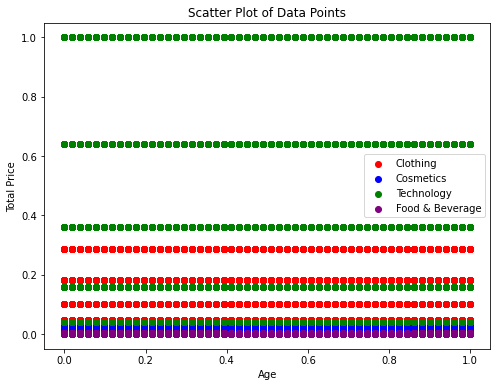

In [105]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a dictionary to map class labels to colors
class_colors = {'Clothing': 'red', 'Cosmetics': 'blue', 'Technology': 'green', 'Food & Beverage': 'purple'}

# Plotting the scatter plot
plt.figure(figsize=(8, 6))

for category, color in class_colors.items():
    class_data = df_normalized[df_normalized['category'] == category]
    plt.scatter(class_data['normalized_age'], class_data['normalized_price'], color=color, label=category)

plt.xlabel('Age')
plt.ylabel('Total Price')
plt.title('Scatter Plot of Data Points')
plt.legend()
plt.show()

It looks like our dataset has a very strange spread - It looks like every category has multiple "levels" of cost and they remain consistent across the ages. I wanted to plot out the means for each of the datasets, to see where they are located. 

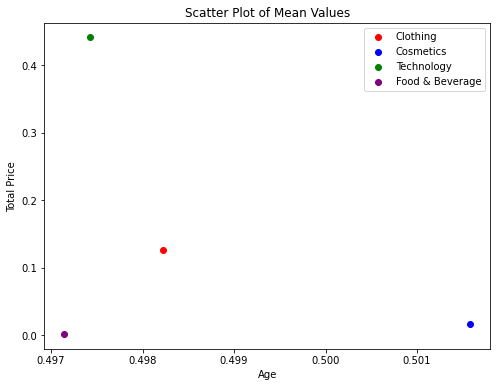

In [106]:
# Create a dictionary to map class labels to colors
class_colors = {'Clothing': 'red', 'Cosmetics': 'blue', 'Technology': 'green', 'Food & Beverage': 'purple'}

class_means = df_normalized.groupby('category').mean()

plt.figure(figsize=(8, 6))

for category, color in class_colors.items():
    mean_age = class_means.loc[category, 'normalized_age']
    mean_price = class_means.loc[category, 'normalized_price']
    plt.scatter(mean_age, mean_price, color=color, label=category)

plt.xlabel('Age')
plt.ylabel('Total Price')
plt.title('Scatter Plot of Mean Values')
plt.legend()
plt.show()

It looks like the means for each dataset are distinctly located and very different from each other. As mentione before, this unusual spread of the dataset could be the reasoning behind the 100% accuracy. 

Lets look at a plot of accuracy vs. k to see how it changes as we increase the k for this particular dataset. 

### Accuracy vs. K 

In [107]:
# Split the data into features and target
X = df_dummy
y = df['category']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Text(0, 0.5, 'Accuracy')

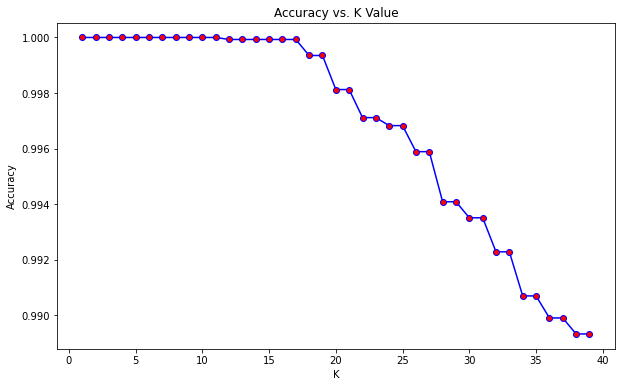

In [108]:
acc = []
for i in range(1,40):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    acc.append(accuracy_score(y_test, yhat))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,40),acc,color = 'blue', 
         marker='o',markerfacecolor='red')
plt.title('Accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')

Text(0, 0.5, 'F1-score')

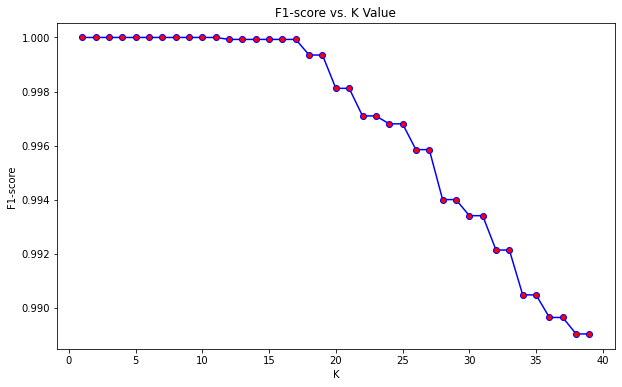

In [109]:
fscore = []
for i in range(1,40):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    fscore.append(f1_score(y_test, yhat,  average="weighted"))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,40),fscore,color = 'blue', 
         marker='o',markerfacecolor='red')
plt.title('F1-score vs. K Value')
plt.xlabel('K')
plt.ylabel('F1-score')

It looks like the accuracy pretty much remains at a 100% until just over k=15 where it starts to drop. However, even though the drop looks steep, it does not drop by a lot in magnitude, only going to just less than 99% accuracy even with k = 40. We see that the F1-score follows a similar structure as well, remaining at a 100% until about k = 20. It looks like for the nature of this dataset where the distribition is such that the mean and standard deviations for the relevant feature that we are using (total_price) is so different from category to category, KNN, a distance-based algorithm, seems to be able to segment the categories really well due to this distribution. 

## Conclusion

Naive-Bayes Performs Best due to Complexity of the model, whereas Naive-Bayes is more simpler and general. Due to the unusual nature of the distribution of this dataset, KNN -  a distanced based algorithm - performs very well in classifying the data points into different clusters. If we had more relevant features for classifying categorues with greater variation, we would have been able to create a much more informative models. Unfortunately, as we only had to go off of total_price and age (as gender or shopping mall were deemed not as important), .....

## Policy Recommendation 
The performance of these models could be improved by: 